# The Ising Model

## Imports

In [1]:
from jax import numpy as jnp
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
from jax import lax, ops, vmap, jit, grad, random, lax

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
from melange_lite.magnets.utils import *
from melange_lite.magnets.ising_modell import IsingsModellSMCMCMCSampler, TrainableIsingsModellSMCSampler

# MCMC SMC Sampler with EXP
run a simple SMC example with EXP and see what the work trajectories look like, eh?

In [4]:
N=1000
L=32
T = 10
direction = [0,1]
smc_factory = IsingsModellSMCMCMCSampler(T, N, direction, L, full_scan=True)
smc_work_fn = smc_factory.works()


def work_fn(seed):
    param_dict = {'seed': seed, 'kernel_parameters': jnp.zeros((T,3))}
    wks = smc_work_fn(param_dict)
    cumulative_works = jnp.cumsum(wks, axis=0)
    return cumulative_works


In [5]:
run_seed = random.PRNGKey(45324623)
works = work_fn(run_seed)

Text(0, 0.5, 'work / kT')

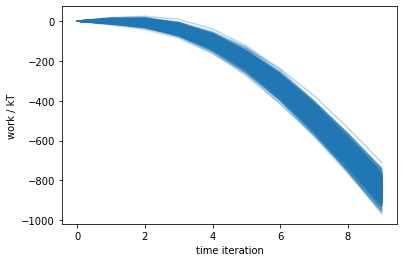

In [6]:
for i in range(N):
    plt.plot(works[:,i], color=colors[0], alpha=0.3)
plt.xlabel(f"time iteration")
plt.ylabel(f"work / kT")

In [7]:
from melange_lite.utils.analysis import *

estimate the free energy with Jarzynski estimator

In [8]:
free_energy(works[-1,:])

DeviceArray(-961.98120687, dtype=float64)

In [9]:
free_energies = bootstrap(works[-1,:], random.PRNGKey(34), free_energy, 100000, {})

Text(0.5, 0, 'bootstrapped free energy / kT')

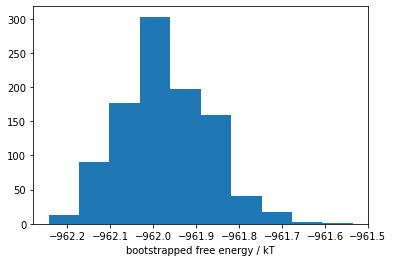

In [10]:
plt.hist(free_energies)
plt.xlabel(f"bootstrapped free energy / kT")

so the variance is only about a nat. but the bias is _huge_

In [11]:
ESS(works[-1,:])

DeviceArray(0.00100015, dtype=float64)

and the effective samples size (ESS) is ~1e-3 (also, bad)

# Variable T MCMC SMC Sampler with EXP
Here, I use a $\pi_t$-invariant $k_t$ forward kernel and run a sequence for forward MCMC SMC Samplers at varying times with a linear $kT$ annealing scheme

In [12]:
N=10
L=32

import tqdm
Ts = [10, 100, 500, 1000]
forward_works = []
direction = [0,1]
seed = random.PRNGKey(23423)
for i in range(len(Ts)):
    print(f"running time length {i}")
    T = Ts[i]
    smc_factory = IsingsModellSMCMCMCSampler(T, N, direction, L, full_scan=True)
    smc_work_fn = smc_factory.works()
    
    @jit
    def work_fn(seed):
        param_dict = {'seed': seed, 'kernel_parameters': jnp.zeros((T,3))}
        wks = smc_work_fn(param_dict)
        cumulative_works = jnp.cumsum(wks, axis=0)[-1]
        return cumulative_works
    run_list = []
    for q in tqdm.trange(10):
        run_seed, seed = random.split(seed)
        works = work_fn(run_seed)
        run_list.append(works)
    forward_works.append(np.array(run_list).flatten())
    

  0%|          | 0/10 [00:00<?, ?it/s]

running time length 0


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 1


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 2


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 3


100%|██████████| 10/10 [01:28<00:00,  8.81s/it]


In [13]:
true_f = -1339.27 # (cite)

In [14]:

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

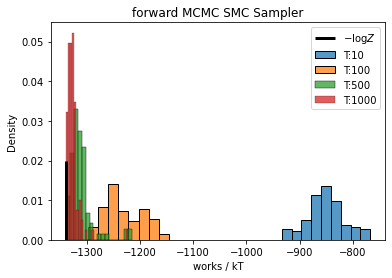

In [15]:
for i in range(len(Ts)):
    T = Ts[i]
    sns.histplot(forward_works[i], stat='density', color = colors[i], label=f"T:{T}")
plt.vlines(true_f, ymin=0, ymax=0.02, color='k', label="$- \log Z$", lw=3)
plt.title(f"forward MCMC SMC Sampler")
# plt.xlim(true_f - 10, true_f + 10)
plt.xlabel(f"works / kT")
plt.legend()

now, let's plot the free energies...

In [16]:
seed = random.PRNGKey(34234)
bootstrapped_free_energies = []
for i in range(len(Ts)):
    seed, run_seed = random.split(seed)
    free_energies = bootstrap(forward_works[i], run_seed, free_energy, 10000, {})
    bootstrapped_free_energies.append(free_energies)

In [17]:
bootstrapped_free_energies = np.array(bootstrapped_free_energies)

In [18]:
bootstrapped_free_energies.shape

(4, 100)

compute MSE


In [19]:
MSE = lambda x: (true_f - np.mean(x))**2 + np.var(x)


In [20]:
MSEs = np.array([MSE(x) for x in bootstrapped_free_energies])

In [21]:
MSEs

array([1.68484254e+05, 2.05864334e+03, 1.84399521e+01, 8.83824917e+00])

Text(0.5, 0, 'num annealing steps')

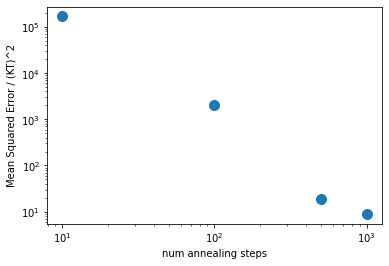

In [22]:
plt.plot(Ts, MSEs, ls='None', marker='o', markersize=10)
plt.xscale('log')
plt.yscale('log')
plt.ylabel("Mean Squared Error / (KT)^2")
plt.xlabel(f"num annealing steps")

Text(0, 0.5, 'free energy variance')

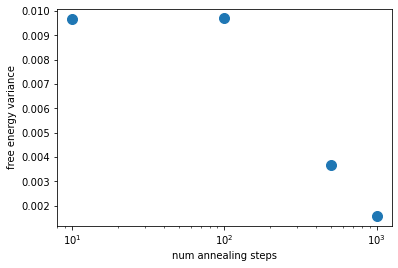

In [23]:
plt.plot(Ts, [np.var(i) for i in bootstrapped_free_energies], ls='None', marker='o', markersize=10)
plt.xscale('log')
plt.xlabel("num annealing steps")
plt.ylabel(f"free energy variance")

so it seems like all of the error is coming from the bias...this might be a problem for our method...

we can also do this in the backward direction*

In [24]:
N=10
L=32

import tqdm
Ts = [10, 100, 500, 1000]
backward_works = []
direction = [1,0]
seed = random.PRNGKey(23423)
for i in range(len(Ts)):
    print(f"running time length {i}")
    T = Ts[i]
    smc_factory = IsingsModellSMCMCMCSampler(T, N, direction, L, full_scan=True)
    smc_work_fn = smc_factory.works()
    
    @jit
    def work_fn(seed):
        param_dict = {'seed': seed, 'kernel_parameters': jnp.zeros((T,3))}
        wks = smc_work_fn(param_dict)
        cumulative_works = jnp.cumsum(wks, axis=0)[-1]
        return cumulative_works
    
    run_list = []
    for q in tqdm.trange(10):
        run_seed, seed = random.split(seed)
        works = work_fn(run_seed)
        run_list.append(works)
    backward_works.append(np.array(run_list).flatten())

  0%|          | 0/10 [00:00<?, ?it/s]

running time length 0


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 1


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 2


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 3


100%|██████████| 10/10 [01:17<00:00,  7.78s/it]


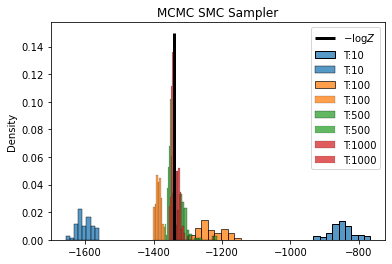

In [25]:
for i in range(len(Ts)):
    T = Ts[i]
    sns.histplot(forward_works[i], stat='density', color = colors[i], label=f"T:{T}")
    sns.histplot(-backward_works[i], stat='density', color = colors[i], label=f"T:{T}")
plt.vlines(true_f, ymin=0, ymax=0.15, color='k', label="$- \log Z$", lw=3)
plt.title(f"MCMC SMC Sampler")
#plt.xlim(true_f - 20, true_f + 20)
plt.legend()

so it looks like we can get somewhere...

can we plot the free energy from EXP fwd/bkwd/bar/symmetric estimator?!

In [26]:
from pymbar import BAR

In [27]:
#compute the BAR estimates
def bootstrap_BAR(forward_works, backward_works, num_bootstraps):
    BARs = []
    for i in range(num_bootstraps):
        random_fwd = np.random.choice(forward_works, len(forward_works))
        random_bkwd = np.random.choice(backward_works, len(backward_works))
        dg, ddg = BAR(random_fwd, random_bkwd)
        BARs.append(dg)
    return np.array(BARs)

In [28]:
bar_estimates = []
for i in range(len(Ts)):
    bootstraps = bootstrap_BAR(forward_works[i], backward_works[i], 1000)
    bar_estimates.append(bootstraps)

In [29]:
BAR_MSE = [MSE(x) for x in bar_estimates]

In [30]:
BAR_MSE

[8678.208645873743, 69.92504288584553, 2.4549924836181285, 0.12355136420696507]

In [32]:
from melange_lite.utils.analysis import bootstrap, symmetric_f, free_energy, there_and_back_f

In [33]:
symm, exp_fwd, exp_bkwd, tb = [], [], [], []
for i in range(len(Ts)):
    print(i)
    _fwd_work, _bkwd_work = forward_works[i], backward_works[i]
    interim_symm, interim_exp_fwd, interim_exp_bkwd, interim_tb = [], [], [], []
    for i in range(1000):
        fwd_work = np.random.choice(_fwd_work, len(_fwd_work))
        bkwd_work = np.random.choice(_bkwd_work, len(_bkwd_work))
        exp_f = free_energy(fwd_work)
        exp_b = free_energy(bkwd_work)
        _symm = symmetric_f(fwd_work, bkwd_work)
        _tb = there_and_back_f(fwd_work, bkwd_work)
        interim_symm.append(_symm)
        interim_exp_fwd.append(exp_f)
        interim_exp_bkwd.append(-exp_b)
        interim_tb.append(_tb)
    symm.append(np.array(interim_symm))
    exp_fwd.append(np.array(interim_exp_fwd))
    exp_bkwd.append(np.array(interim_exp_bkwd))
    tb.append(interim_tb)

0
1
2
3


In [34]:
EXP_MSE = [MSE(x) for x in exp_fwd]
SYM_MSE = [MSE(x) for x in symm]
TB_MSE = [MSE(x) for x in tb]

In [35]:
EXP_MSE

[169800.1760325474, 2363.3335071482334, 22.35003035664572, 9.690647733919173]

In [36]:
TB_MSE

[169229.42900205142, 2296.729051746141, 16.439267130489238, 5.9190386429818345]

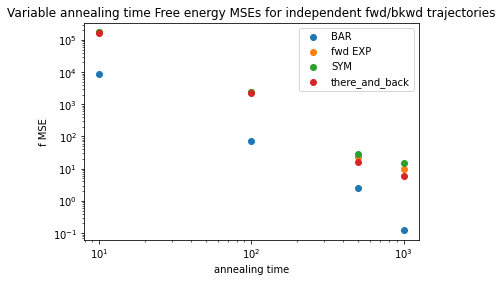

In [38]:
for i in range(len(Ts)):
    plt.scatter(Ts[i], BAR_MSE[i], color=colors[0], label='BAR' if i==len(Ts)-1 else None)
    plt.scatter(Ts[i], EXP_MSE[i], color=colors[1], label='fwd EXP' if i==len(Ts)-1 else None)
    plt.scatter(Ts[i], SYM_MSE[i], color = colors[2], label='SYM' if i==len(Ts)-1 else None)
    plt.scatter(Ts[i], TB_MSE[i], color = colors[3], label="there_and_back" if i==len(Ts)-1 else None)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"annealing time")
plt.ylabel("f MSE")
plt.title("Variable annealing time Free energy MSEs for independent fwd/bkwd trajectories")
plt.legend()

of course, all of these data are predicated on you being able to sample equilibrium at lambda=0,1...

# Symmetric Protocol MCMC SMC Sampler
let's try to define a series of symmetric protocols and run them with an MCMC SMC Sampler...

In [66]:
N=248
L=32
T = 5
direction = [0,1]
kT_schedule = jnp.append(jnp.linspace(0,1,T), jnp.linspace(1,0,T)[1:])
IW_parameters = jnp.hstack([jnp.ones(2*T - 1)[..., jnp.newaxis], #J
                                                                         jnp.zeros(2*T - 1)[..., jnp.newaxis], #h
                                                                         kT_schedule[..., jnp.newaxis] #beta
                                                                          ])
print(len(IW_parameters))

9


In [172]:
smc_factory = TrainableIsingsModellSMCSampler(T=len(IW_parameters), 
                                              N=N, 
                                              IW_parameters= IW_parameters,
                                              L=L, 
                                              full_scan=True,
                                              MCMC=False
                                              )
smc_work_fn = smc_factory.works()
kernel_kT_schedule = jnp.append(jnp.linspace(0,1,T)[1:], jnp.linspace(1,0,T)[:-1])
kernel_kT_schedule_len = len(kernel_kT_schedule)
kernel_parameters = jnp.hstack([jnp.ones(kernel_kT_schedule_len)[..., jnp.newaxis], #J
                                jnp.zeros(kernel_kT_schedule_len)[..., jnp.newaxis], #h
                                kernel_kT_schedule[..., jnp.newaxis] #beta
                               ])

In [173]:
kernel_parameters

DeviceArray([[1.        , 0.        , 0.11111111],
             [1.        , 0.        , 0.22222222],
             [1.        , 0.        , 0.33333333],
             [1.        , 0.        , 0.44444444],
             [1.        , 0.        , 0.55555556],
             [1.        , 0.        , 0.66666667],
             [1.        , 0.        , 0.77777778],
             [1.        , 0.        , 0.88888889],
             [1.        , 0.        , 1.        ],
             [1.        , 0.        , 1.        ],
             [1.        , 0.        , 0.88888889],
             [1.        , 0.        , 0.77777778],
             [1.        , 0.        , 0.66666667],
             [1.        , 0.        , 0.55555556],
             [1.        , 0.        , 0.44444444],
             [1.        , 0.        , 0.33333333],
             [1.        , 0.        , 0.22222222],
             [1.        , 0.        , 0.11111111]], dtype=float64)

In [174]:
def work_fn(seed):
    param_dict = {'seed': seed, 'kernel_parameters': kernel_parameters}
    wks = smc_work_fn(param_dict)
    cumulative_works = jnp.cumsum(wks, axis=0)
    return cumulative_works

In [175]:
seed = random.PRNGKey(45324623)
works = work_fn(seed)

In [176]:
works.shape

(19, 248)

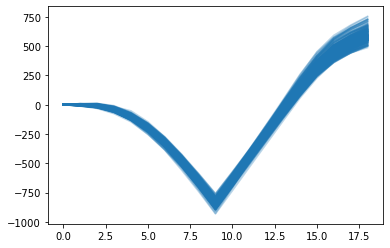

In [177]:
for i in range(N):
    plt.plot(works[:,i], color=colors[0], alpha=0.3)

check to make sure the sequence of IW kT vals and kernel kT values are correct...

In [178]:
# for i in range(smc_factory.T - 1):
#     print(f"kernel_parameter: {kernel_parameters[i][-1]}")
#     print(f"old IW parameter: {kT_schedule[i]}")
#     print(f"new IW parameter: {kT_schedule[i+1]}")
#     print()

In [179]:
len(works[:,0])

19

In [181]:
works.shape

(19, 248)

In [182]:
works[:,0]

DeviceArray([   0.        ,   -0.88888889,   -9.33333333,  -38.66666667,
              -99.55555556, -196.88888889, -323.11111111, -468.44444444,
             -636.        , -814.66666667, -624.        , -428.88888889,
             -232.44444444,  -37.33333333,  144.88888889,  300.        ,
              411.55555556,  491.11111111,  550.22222222], dtype=float64)

In [183]:
works[8,1]

DeviceArray(-657.33333333, dtype=float64)

In [184]:
works[9,1]

DeviceArray(-846.66666667, dtype=float64)

In [185]:
works[10,1]

DeviceArray(-647.55555556, dtype=float64)

In [186]:
forward_works = works[9,:]
backward_works = works[-1,:] - forward_works

In [187]:
symmetric_f(forward_works, backward_works)

DeviceArray(-926.70046289, dtype=float64)

In [188]:
symmetric_f_v2(forward_works, backward_works)

DeviceArray(-926.70046289, dtype=float64)

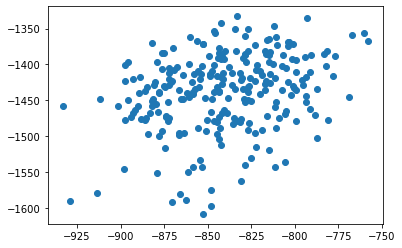

In [191]:
plt.scatter(forward_works, -backward_works)


In [192]:
N = len(forward_works)
max_forwards = jnp.max(forward_works)
offset_forwards = forward_works - max_forwards
offset_backwards = backward_works + max_forwards

In [196]:
max_forwards

DeviceArray(-758.22222222, dtype=float64)

In [197]:
summant = (jnp.exp(offset_forwards) + jnp.exp(-offset_backwards))

(array([246.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.39069052e-76, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

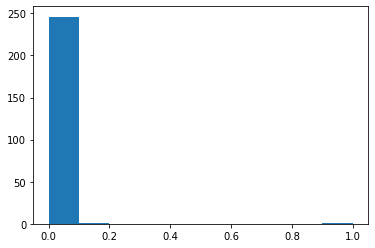

In [198]:
plt.hist(summant)

alright, so it doesn't _look_ buggy. However, it does look like few values are dominating the free energy estimate...

# TODO:
- train the trainable MCMC SMC Sampler on temperature (EXP)
- build the spatial ising model
    - allow for spatially-varying magnetic field
    - try from beta=0 to beta=1...no external magnetic field
- train the spatial ising model
- train the spatial ising model with a spatially-varying magnetic field (EXP)
- do the above (SYMMETRIC)